Todo: 
    - Create lowercase dataset (make_dataset.py)
    - Delete UPPPER and Title words after checking
    - Find most likely relation type: "A B", "B A", "AB", "BA" 
    - Store as one-hot data...
    - Run NLTK
    - Compile new feature dataset
    - Split dataset (split data.ipynb)
    
    
Todo 2:
    - do something about the low w2v match in lowercased dataset

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [5]:
df = pd.read_csv('../data/processed/wordgame_20170829.csv') # original cAsE
df['word'] = df['word'].astype(str)
df['association'] = df['association'].astype(str)

# later
with open('../data/processed/sources.csv') as f:
    sources_list = f.read().splitlines()
print(sources_list)
df.head()

['AC', 'BC', 'CC', 'ECF', 'GOG', 'LEF', 'SAS', 'TF', 'U2', 'WP']


,user,forum,word,association,forumID
0,Hickory,GOG,palm,tree,4
1,boopme,BC,elbows,fusilli,1
2,Smogg,GOG,paranormal,apparition,4
3,ruennsheng,WP,hominid,abstract,9
4,Jack Jackson,SAS,sweet,candy,6


In [61]:
print("Dataset shape: " + str(df.shape))
print("Number of sources: " + str(len(df['forumID'].unique())))

Dataset shape: (330395, 5)
Number of sources: 10


### Syntactic features
...

In [43]:
df['tf'] = (100*df.groupby(['association'])['association'].transform('count'))/len(df) #percentage
print(df.word.value_counts().head(7).index.tolist())
print("Mean: "+str(df.tf.mean())+"\tMedian: "+str(df.tf.median()))

['water', 'music', 'time', 'love', 'money', 'fire', 'food']
Mean: 0.0188429733414	Median: 0.008172036501763041


In [41]:
df['pair'] = df.apply(lambda r: str(r.word) + ":" + str(r.association), axis=1)
df['pf'] = (100*df.groupby(['pair'])['pair'].transform('count'))/len(df)
df.pair.value_counts().head(7).index.tolist()

['me:you',
 'man:woman',
 'time:clock',
 'up:down',
 'meow:meow',
 'green:grass',
 'house:home']

In [64]:
df['len1'] = df['word'].apply(lambda x:len(x))
df['len2'] = df['association'].apply(lambda x:len(x))
df['ldiff'] = df['len1'] - df['len2'] # length difference
print("Mean: "+str(df.len1.mean())+"\tMedian: "+str(df.len1.median()))  
print("Mean: "+str(df.ldiff.mean())+"\tMedian: "+str(df.ldiff.median()))  

Mean: 6.77352865509	Median: 6.0
Mean: -0.000853523812406	Median: 0.0


In [65]:
import Levenshtein
df['levenshtein'] = df.apply(lambda r:Levenshtein.distance(r.word, r.association), axis=1)
print("Mean: "+str(df.levenshtein.mean())+"\tMedian: "+str(df.levenshtein.median()))

Mean: 6.80292982642	Median: 6.0


In [66]:
import os
df['prefix'] = df.apply(lambda r: os.path.commonprefix([r.word, r.association]), axis=1)
df['pl']= (df['prefix'].apply(lambda x: len(x)))/(0.5*(df['len1']+df['len2']))
df['suffix'] = df.apply(lambda r: os.path.commonprefix([r.word[::-1], r.association[::-1]]), axis=1)
df['suffix'] = df['suffix'].apply(lambda x:x[::-1]) #re-reverse suffix
df['sl']= (df['suffix'].apply(lambda x: len(x)))/(0.5*(df.len1+df.len2))

print(df.prefix.value_counts().head(20).index.tolist())
print("Mean: "+str(df.pl.mean())+"\tMedian: "+str(df.pl.median()))
print(df.suffix.value_counts().head(20).index.tolist())
print("Mean: "+str(df.sl.mean())+"\tMedian: "+str(df.sl.median()))

['', 's', 'c', 'b', 'p', 'm', 'f', 't', 'd', 'a', 'w', 'h', 'r', 'g', 'l', 'e', 're', 'co', 'n', 'i']
Mean: 0.0340372050678	Median: 0.0
['', 'e', 's', 't', 'y', 'n', 'ed', 'er', 'ing', 'r', 'd', 'es', 'l', 'a', 'tion', 'k', 'ion', 'on', 'o', 'ation']
Mean: 0.048668958518	Median: 0.0


## Semantic features
### Word2Vec

In [67]:
from gensim.models.keyedvectors import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format('../data/external/GoogleNews-vectors-negative300.bin', binary=True)
print('Loaded word embeddings')

Loaded word embeddings


In [68]:
df['inw2v1'] = df['word'].apply(lambda x:(x in w2v_model.vocab))
df['inw2v2'] = df['association'].apply(lambda x:(x in w2v_model.vocab)) 
df['inw2v'] = df.apply(lambda r:(r.inw2v1 & r.inw2v2), axis=1)
print("Mean: "+str(df.inw2v.mean()))

'''
This is something for when I'm really bored or something <3

df['isUpper1'] = False
df['isUpper2'] = False
df.ix[~df.inw2v1, 'isUpper1'] = df.ix[~df.inw2v1].apply(lambda r:((r.word.upper() in w2v_model.vocab)), axis=1) 
df.ix[~df.inw2v2, 'isUpper2'] = df.ix[~df.inw2v2].apply(lambda r:((r.association.upper() in w2v_model.vocab)), axis=1) 
df['inw2v'] = df.apply(lambda r:(((r.inw2v1 | r.isUpper1) & (r.inw2v2 | r.isUpper2))), axis=1)
print("Mean: "+str(df.inw2v.mean()))

df.ix[~df.inw2v1, 'inw2v1'] = df.ix[~df.inw2v1].apply(lambda r:((r.word.title() in w2v_model.vocab)), axis=1) 
df.ix[~df.inw2v2, 'inw2v2'] = df.ix[~df.inw2v2].apply(lambda r:((r.association.title() in w2v_model.vocab)), axis=1) 
df['inw2v'] = df.apply(lambda r:(r.inw2v1 & r.inw2v2), axis=1)
print("Mean: "+str(df.inw2v.mean()))

'''

Mean: 0.819273899423


'\nThis is something for when I\'m really bored or something <3\n\ndf[\'isUpper1\'] = False\ndf[\'isUpper2\'] = False\ndf.ix[~df.inw2v1, \'isUpper1\'] = df.ix[~df.inw2v1].apply(lambda r:((r.word.upper() in w2v_model.vocab)), axis=1) \ndf.ix[~df.inw2v2, \'isUpper2\'] = df.ix[~df.inw2v2].apply(lambda r:((r.association.upper() in w2v_model.vocab)), axis=1) \ndf[\'inw2v\'] = df.apply(lambda r:(((r.inw2v1 | r.isUpper1) & (r.inw2v2 | r.isUpper2))), axis=1)\nprint("Mean: "+str(df.inw2v.mean()))\n\ndf.ix[~df.inw2v1, \'inw2v1\'] = df.ix[~df.inw2v1].apply(lambda r:((r.word.title() in w2v_model.vocab)), axis=1) \ndf.ix[~df.inw2v2, \'inw2v2\'] = df.ix[~df.inw2v2].apply(lambda r:((r.association.title() in w2v_model.vocab)), axis=1) \ndf[\'inw2v\'] = df.apply(lambda r:(r.inw2v1 & r.inw2v2), axis=1)\nprint("Mean: "+str(df.inw2v.mean()))\n\n'

In [69]:
df[~df['inw2v']].head(20)

,user,forum,word,association,forumID,tf,pair,pf,len1,len2,ldiff,levenshtein,prefix,pl,suffix,sl,inw2v1,inw2v2,inw2v
8,Animeguy,ECF,claim,e-cigarettes,3,0.000303,claim:e-cigarettes,0.000303,5,12,-7,10,,0.000000,,0.000000,True,False,False
10,TwisterBE,GOG,a,robot,4,0.018765,a:robot,0.000303,1,5,-4,5,,0.000000,,0.000000,False,True,False
11,Golden Wheat,SAS,missing,spark-plug,6,0.000303,missing:spark-plug,0.000303,7,10,-3,9,,0.000000,g,0.117647,True,False,False
13,Judge,AC,role-play,d&d,0,0.000605,role-play:d&d,0.000303,9,3,6,9,,0.000000,,0.000000,False,False,False
20,cruachan,WP,bionic woman,styx,9,0.001816,bionic woman:styx,0.000303,12,4,8,12,,0.000000,,0.000000,False,False,False
23,StrongGirl,U2,warm,the tropics,8,0.000303,warm:the tropics,0.000303,4,11,-7,10,,0.000000,,0.000000,True,False,False
27,Noca,SAS,jacket,full metal,6,0.000303,jacket:full metal,0.000303,6,10,-4,8,,0.000000,,0.000000,True,False,False
30,le_chevalier,GOG,ace,spadille,4,0.000303,ace:spadille,0.000303,3,8,-5,6,,0.000000,e,0.181818,True,False,False
31,DarrylZero,WP,superhero,nemesises,9,0.000303,superhero:nemesises,0.000303,9,9,0,8,,0.000000,,0.000000,True,False,False
32,TheAP,WP,leave it to beaver,movie,9,0.103210,leave it to beaver:movie,0.000303,18,5,13,15,,0.000000,,0.000000,False,True,False


In [70]:
df['sim'] = 0
df.ix[df.inw2v, 'sim'] = df.ix[df.inw2v].apply(lambda r:w2v_model.similarity(r.word, r.association), axis=1)
print("Mean: "+str(df.sim.mean())+"\tMedian: "+str(df.sim.median()))
print(df[(df.sim<0.18)&(df.sim>0.17)].pair.head().tolist())

Mean: 0.220326584801	Median: 0.18991696406622194
['clock:work', 'singer:microphone', 'rattle:snake', 'woman:devil', 'bar:ban']


In [71]:
# Relationships...
df['rel1'] = df.apply(lambda r:(str(r.word + "_" + r.association) in w2v_model.vocab), axis=1)
print("Mean: "+str(df.rel1.mean())+"\tMedian: "+str(df.rel1.median()))

Mean: 0.0415896124336	Median: 0.0


In [72]:
df['rel2'] = df.apply(lambda r:(str(r.word + r.association) in w2v_model.vocab), axis=1) #compound
print("Mean: "+str(df.rel2.mean())+"\tMedian: "+str(df.rel2.median()))

Mean: 0.0388988937484	Median: 0.0


In [73]:
df['rel3'] = df.apply(lambda r:(str(r.association + "_" + r.word) in w2v_model.vocab), axis=1)
print("Mean: "+str(df.rel3.mean()))

Mean: 0.0283963135035


In [74]:
df['rel4'] = df.apply(lambda r:(str(r.association + r.word) in w2v_model.vocab), axis=1)
print("Mean: "+str(df.rel4.mean()))

Mean: 0.018940964603


In [75]:
print(df[df.rel1].pair.head(10).tolist())

['palm:tree', 'fishing:boat', 'rattle:snake', 'snow:melt', 'burger:fries', 'city:slickers', 'hymn:sheet', 'scuba:gear', 'mop:broom', 'sour:grapes']


In [76]:
#df['wv1'] = df['word'].apply(lambda x: np.zeros(300)) 
#df['wv2'] = df['word'].apply(lambda x: np.zeros(300)) 

#df.ix[df.inw2v, 'wv1'] = df.ix[df.inw2v, 'word'].apply(lambda x: w2v_model.word_vec(x)) 
#df.ix[df.inw2v, 'wv2'] = df.ix[df.inw2v, 'association'].apply(lambda x: w2v_model.word_vec(x)) 

In [77]:
w2v_model = None # in the future use garbage collection! 
# now memory can be reclamed if needed, does not free memory instantly

### NLTK

In [78]:
from itertools import chain
from nltk.corpus import wordnet

In [79]:
def isSynonym(r):
    synonyms = wordnet.synsets(r.word)
    lemmas = set(chain.from_iterable([w.lemma_names() for w in synonyms]))
    return (r.association in lemmas)

df['synonym'] = df.apply(isSynonym, axis=1)
print("Mean: " + str(df.synonym.mean()))

Mean: 0.0386567593335


In [80]:
print(df[df['synonym']].pair.tail())

330269      hit:strike
330315    scorch:singe
330346     buck:dollar
330356       call:name
330357    allow:permit
Name: pair, dtype: object


In [81]:
def isAntonym(r):
    h = []
    for syn in wordnet.synsets(r.word):
        for l in syn.lemmas():
            if l.antonyms():
                h.append(l.antonyms()[0].name().split('.')[0]) # how !?! 
    return (r.association in h)

df['antonym'] = df.apply(isAntonym, axis=1)
print(df.antonym.mean())    

0.0088046126606


In [82]:
df[df['antonym']].pair.tail()

329848    inside:outside
330001           up:down
330037        lost:found
330142     end:beginning
330161           down:up
Name: pair, dtype: object

In [83]:
len(df[df['antonym']])

2909

In [84]:
def isHypernym(r):
    h = []
    for syn in wordnet.synsets(r.word):
        if syn.hypernyms():
#            print(syn.hypernyms()[0].name().split('.')[0])
            h.append(syn.hypernyms()[0].name().split('.')[0]) # how !?! 
    return (r.association in h)

df['hypernym'] = df.apply(isHypernym, axis=1)
print(df.hypernym.mean())      

0.0213290152696


In [85]:
def isHyponym(r):
    h = []
    for syn in wordnet.synsets(r.word):
        if syn.hyponyms():
            h.append(syn.hyponyms()[0].name().split('.')[0]) # how !?! 
    return (r.association in h)

df['hyponym'] = df.apply(isHyponym, axis=1)
print(df.hyponym.mean())      

0.00450672679671


In [86]:
print(df[df['hypernym']].pair.head())
print(df[df['hyponym']].pair.head())

print(len(df[df['synonym']]))

0                 palm:tree
16              stream:flow
85             bandit:thief
313    solitary:confinement
403       cyrillic:alphabet
Name: pair, dtype: object
277        loner:hermit
289       cover:blanket
1291       love:romance
1305       vision:dream
1313    dream:nightmare
Name: pair, dtype: object
12772


In [87]:
df.head(10)

,user,forum,word,association,forumID,tf,pair,pf,len1,len2,...,rel1,rel2,rel3,rel4,wv1,wv2,synonym,antonym,hypernym,hyponym
0,Hickory,GOG,palm,tree,4,0.102604,palm:tree,0.002724,4,4,...,True,False,False,False,"[0.00915527, -0.207031, -0.337891, 0.233398, -...","[0.484375, 0.122559, -0.157227, 0.034668, -0.2...",False,False,True,False
1,boopme,BC,elbows,fusilli,1,0.000605,elbows:fusilli,0.000303,6,7,...,False,False,False,False,"[-0.168945, -0.244141, 0.00787354, 0.212891, -...","[-0.146484, -0.0449219, -0.00927734, 0.28125, ...",False,False,False,False
2,Smogg,GOG,paranormal,apparition,4,0.002421,paranormal:apparition,0.000303,10,10,...,False,False,False,False,"[0.0825195, -0.060791, 0.0732422, 0.0189209, -...","[0.300781, 0.124023, -0.0549316, 0.115723, -0....",False,False,False,False
3,ruennsheng,WP,hominid,abstract,9,0.006659,hominid:abstract,0.000303,7,8,...,False,False,False,False,"[0.15332, 0.0961914, -0.277344, 0.511719, -0.1...","[0.257812, -0.251953, 0.0441895, 0.285156, -0....",False,False,False,False
4,Jack Jackson,SAS,sweet,candy,6,0.055086,sweet:candy,0.004540,5,5,...,False,False,False,False,"[0.0869141, 0.0300293, -0.0458984, 0.117676, 0...","[-0.0500488, -0.232422, -0.0308838, 0.472656, ...",False,False,False,False
5,zurb,AC,clock,work,0,0.061744,clock:work,0.003329,5,4,...,False,True,False,False,"[-0.078125, 0.0517578, 0.316406, 0.0708008, -0...","[-0.0756836, 0.0336914, -0.0649414, 0.131836, ...",False,False,False,False
6,Colhad75,SAS,dream,stormy,6,0.007264,dream:stormy,0.000303,5,6,...,False,False,False,False,"[-0.074707, -0.101562, 0.129883, 0.022583, 0.2...","[0.0625, 0.259766, -0.210938, -0.18457, 0.1835...",False,False,False,False
7,Scarabola,WP,girth,heft,9,0.000303,girth:heft,0.000303,5,4,...,False,False,False,False,"[0.112305, 0.361328, -0.0693359, -0.0297852, -...","[0.355469, 0.170898, -0.233398, -0.11084, 0.08...",False,False,False,False
8,Animeguy,ECF,claim,e-cigarettes,3,0.000303,claim:e-cigarettes,0.000303,5,12,...,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False,False
9,Toad Licker,SAS,fishing,boat,6,0.058112,fishing:boat,0.002421,7,4,...,True,False,False,False,"[0.019165, 0.0698242, -0.0537109, -0.0354004, ...","[0.244141, 0.115723, -0.176758, -0.279297, -0....",False,False,False,False


### Network features

In [33]:
#pagerank 

import networkx as nx

print("To make comparison easier list of most frequent words is printed below:")
print(df.word.value_counts().head(15).index.tolist())


G = nx.from_pandas_dataframe(df, 'word', 'association', create_using=nx.DiGraph())
pr = nx.pagerank(G, alpha=0.85)
df['pr'] = df['association'].apply(lambda x:pr[x])
print(df.drop_duplicates(['association']).sort_values(by=['pr'], ascending=False).head(15).association.tolist())
# Frequent words:
# Interesting..

To make comparison easier list of most frequent words is printed below:

['water', 'music', 'time', 'love', 'money', 'fire', 'food', 'game', 'house', 'dog', 'ball', 'red', 'man', 'death', 'life']
['water', 'music', 'money', 'food', 'love', 'time', 'life', 'me', 'death', 'dog', 'game', 'movie', 'fire', 'red', 'green']


In [37]:
# in-degree: how often a word replied as association ~= how often it occured in the topics
indegree = G.in_degree()
df['indeg'] = df['association'].apply(lambda x:indegree[x])
print(df.drop_duplicates(['association']).sort_values(by=['indeg'], ascending=False).head(15).association.tolist())

['water', 'music', 'money', 'food', 'love', 'time', 'dog', 'life', 'death', 'game', 'me', 'fire', 'movie', 'green', 'red']


In [38]:
# out-degree: how often a (valid) assocation was given to this word ~= how often it occured in the topics
outdegree = G.out_degree()
df['outdeg'] = df['association'].apply(lambda x:outdegree[x])
print(df.drop_duplicates(['association']).sort_values(by=['outdeg'], ascending=False).head(15).association.tolist())

['water', 'music', 'love', 'food', 'money', 'time', 'death', 'life', 'fire', 'house', 'dog', 'game', 'red', 'green', 'pain']


In [53]:
df[['association','tf','pr','indeg','outdeg']].head(10)
#df.outdeg.head()

,association,tf,pr,indeg,outdeg
0,tree,0.102604,0.000462,150,125
1,fusilli,0.000605,0.000009,2,2
2,apparition,0.002421,0.000028,8,7
3,abstract,0.006659,0.000071,21,15
4,candy,0.055086,0.000392,109,82
5,work,0.061744,0.000365,119,112
6,stormy,0.007264,0.000065,18,15
7,heft,0.000303,0.000004,1,1
8,e-cigarettes,0.000303,0.000008,1,1
9,boat,0.058112,0.000285,95,92


### Feature correlation

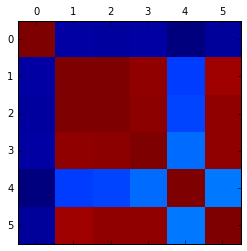

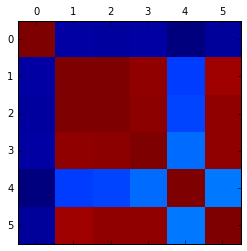

In [57]:
import matplotlib.pylab as plt

plt.matshow(df.corr())
plt.show()

In [58]:
df.head()

,user,forum,word,association,forumID,pr,indeg,outdeg,pair,pf,tf
0,Hickory,GOG,palm,tree,4,0.000462,150,125,palm:tree,0.002724,0.102604
1,boopme,BC,elbows,fusilli,1,0.000009,2,2,elbows:fusilli,0.000303,0.000605
2,Smogg,GOG,paranormal,apparition,4,0.000028,8,7,paranormal:apparition,0.000303,0.002421
3,ruennsheng,WP,hominid,abstract,9,0.000071,21,15,hominid:abstract,0.000303,0.006659
4,Jack Jackson,SAS,sweet,candy,6,0.000392,109,82,sweet:candy,0.004540,0.055086


In [89]:
df = df.drop('wv1',1)
df = df.drop('wv2',1)
df.to_csv("../data/processed/wordgame_20170831_ft.csv", sep=',', index=False)
print('End')

Fin
